## 基于MindSpore框架的UNet-2D案例实现

### 1 模型简介

Unet模型于2015年在论文《U-Net: Convolutional Networks for Biomedical Image Segmentation》中被提出，最初的提出是为了解决医学图像分割问题，用于细胞层面的图像分割任务。

Unet模型是在FCN网络的基础上构建的，但由于FCN无法获取上下文信息以及位置信息，导致准确性较低，Unet模型由此引入了U型结构获取上述两种信息，并且模型结构简单高效、容易构建，在较小的数据集上也能实现较高的准确率。

#### 1.1 模型结构
Unet模型的整体结构由两部分组成，即特征提取网络和特征融合网络，其结构也被称为“编码器-解码器结构”，并且由于网络整体结构类似于大写的英文字母“U”，故得名Unet，在其原始论文中定义的网络结构如图1所示。

<center>
    <img src="https://tva1.sinaimg.cn/large/e6c9d24ely1h5bw5io8tqj20n10fa3zo.jpg" alt="image-20220819101847606" style="zoom:67%;" />
    <br>
    <div style="color:orange;
    display: inline-block;
    color: #999;
    padding: 2px;">图1 Unet网络结构图</div>
</center>

整个模型结构就是在原始图像输入后，首先进行特征提取，再进行特征融合：

a) 左半部分负责特征提取的网络结构（即编码器结构）需要利用两个3x3的卷积核与2x2的池化层组成一个“下采样模块”，每一个下采样模块首先会对特征图进行两次valid卷积，再进行一次池化操作。由此经过4个下采样模块后，原始尺寸为572x572大小、通道数为1的原始图像，转换为了大小为28x28、通道数为1024的特征图。

b) 右半部分负责进行上采样的网络结构（即解码器结构）需要利用1次反卷积操作、特征拼接操作以及两个3x3的卷积核作为一个“上采样模块”，每一个上采样模块首先会对特征图通过反卷积操作使图像尺寸增加1倍，再通过拼接编码器结构中的特征图使得通道数增加，最后经过两次valid卷积。由此经过4个上采样模块后，经过下采样模块的、大小为28x28、通道数为1024的特征图，转换为了大小为388x388、通道数为64的特征图。

c) 网络结构的最后一部分是通过两个1x1的卷积核将经过上采样得到的通道数为64的特征图，转换为了通道数为2的图像作为预测结果输出。
#### 1.2 模型特点

a) 利用拼接操作将低级特征图与高级特征图进行特征融合

b) 完全对称的U型结构使得高分辨率信息和低分辨率信息在目标图片中增加，前后特征融合更为彻底。

c) 结合了下采样时的低分辨率信息（提供物体类别识别依据）和上采样时的高分辨率信息（提供精准分割定位依据），此外还通过融合操作填补底层信息以提高分割精度。


### 2 案例实现

#### 2.1 **环境准备与数据读取**

本案例基于MindSpore-CPU版本实现，在CPU上完成模型训练。

案例实现所使用的数据即ISBI果蝇电镜图数据集，可以从http://brainiac2.mit.edu/isbi_challenge/ 中下载，下载好的数据集包括3个tif文件，分别对应测试集样本、训练集标签、训练集样本，文件路径结构如下：

```
.datasets/
└── ISBI
    ├── test-volume.tif
    ├── train-labels.tif
    └── train-volume.tif
```

其中每个tif文件都由30副图片压缩而成，所以接下来需要获取每个tif文件中所存储的所有图片，将其转换为png格式存储，得到训练集样本对应的30张png图片、训练集标签对应的30张png图片以及测试集样本对应的30张png图片。

/home/ma-user/anaconda3/envs/MindSpore/bin/python
MindSpore version:  1.8.1
The result of multiplication calculation is correct, MindSpore has been installed successfully!
None


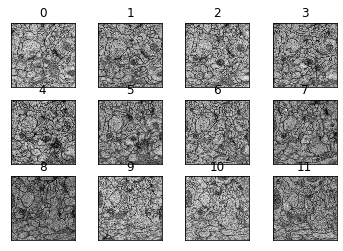

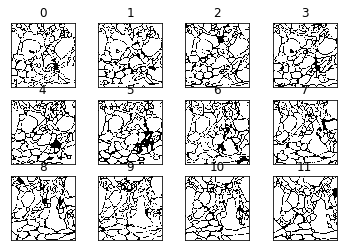

In [1]:
import sys
import mindspore
print(sys.executable)
print(mindspore.run_check())
from PIL import Image, ImageSequence
import math
import numpy as np
import matplotlib.pyplot as plt
#显示下载好的数据
train_image_path = "data/train-volume.tif"
train_masks_path = "data/train-labels.tif"
image = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(train_image_path))])
masks = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(train_masks_path))])

def show_image(image_list,num = 6):
    img_titles = []
    img_draws = []
    for ind,img in enumerate(image_list):
        if ind == num:
            break
        img_titles.append(ind)
        img_draws.append(img)

    for i in range(len(img_titles)):
        if len(img_titles) > 6:
            row = 3
        elif 3<len(img_titles)<=6:
            row = 2
        else:
            row = 1
        col = math.ceil(len(img_titles)/row)
        plt.subplot(row,col,i+1),plt.imshow(img_draws[i],'gray')
        plt.title(img_titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
show_image(image,num = 12)
show_image(masks,num = 12)

具体的实现方式首先是将tif文件转换为数组形式，之后通过io操作将每张图片对应的数组存储为png图像，处理过后的训练集样本及其对应的标签图像如图2所示。将3个tif文件转换为png格式后，针对训练集的样本与标签，将其以2:1的比例，重新划分为了训练集与验证集，划分完成后的文件路径结构如下：

```
.datasets/
└── ISBI
    ├── test_imgs
    │   ├── 00000.png
    │   ├── 00001.png
    │   └── . . . . .
    ├── train
    │   ├── image
    │   │   ├── 00001.png
    │   │   ├── 00002.png
    │   │   └── . . . . .
    │   └── mask
    │       ├── 00001.png
    │       ├── 00002.png
    │       └── . . . . .
    └── val
        ├── image
        │   ├── 00000.png
        │   ├── 00003.png
        │   └── . . . . .
        └── mask
            ├── 00000.png
            ├── 00003.png
            └── . . . . .
```

<center>
    <img src="https://tva1.sinaimg.cn/large/e6c9d24ely1h5bwhda4g2j20fz0chabb.jpg" alt="image-20220819101847606" style="zoom:50%;" />
    <br>
    <div style="color:orange;
    display: inline-block;
    color: #999;
    padding: 2px;">图2 训练集样本及其对应标签</div>
</center>

#### 2.2 数据集创建

在进行上述tif文件格式转换，以及测试集和验证集的进一步划分后，就完成了数据读取所需的所有工作，接下来就需要利用处理好的图像数据，通过一定的图像变换来进行数据增强，并完成数据集的创建。

数据增强部分是引入了mindspore.dataset.vision，针对训练集样本和标签，首先通过A.resize()方法将图像尺寸重新调整为统一大小，之后再进行转置以及水平翻转、垂直翻转，完成针对训练集样本和标签的数据增强。针对验证集的样本和标签，仅通过resize()方法将图像尺寸重新调整为统一大小。

其次数据集的创建部分，首先是定义了Data_Loader类，在该类的__init__函数中，根据传入的data_path参数，确定在数据读取阶段设置好的、训练集和验证集的存储路径，再设置对应的样本和标签路径，并针对训练集和验证集的不同数据增强方法。在该类的__getitem__函数中，通过传入索引值读取训练集或验证集存储路径下的样本和标签图像，并对图像进行对应的数据增强操作，之后再对样本和标签的形状进行转置，就完成了__getitem__函数对样本和标签图像的读取。最后通过定义create_dataset函数，传入data_dir、batch_size等参数，在函数中实例化Data_Loader类获取data_dir，也就是训练集或验证集对应路径下的样本和标签元组对，再通过mindspore.dataset中的GeneratorDataset将元组转换为Tensor，最后通过设定好的batch_size将样本和标签按照batch_size大小分组，由此完成数据集的创建，上述流程对应代码如下：

In [2]:
import os
import cv2
import mindspore.dataset as ds
import glob
import mindspore.dataset.vision as vision_C  #.c_transforms
import mindspore.dataset.transforms as C_transforms #.c_transform
import random
import mindspore
from mindspore.dataset.vision import Inter

def train_transforms(img_size):
    return [
    vision_C.Resize(img_size, interpolation=Inter.NEAREST),
    vision_C.Rescale(1./255., 0.0),
    vision_C.RandomHorizontalFlip(prob=0.5),
    vision_C.RandomVerticalFlip(prob=0.5),
    vision_C.HWC2CHW()
    ]


def val_transforms(img_size):
    return [
    vision_C.Resize(img_size, interpolation=Inter.NEAREST),
    vision_C.Rescale(1/255., 0),
    vision_C.HWC2CHW()
    ]



class Data_Loader:
    def __init__(self, data_path):
        # 初始化函数，读取所有data_path下的图片
        self.data_path = data_path
        self.imgs_path = glob.glob(os.path.join(data_path, 'image/*.png'))
        self.label_path = glob.glob(os.path.join(data_path, 'mask/*.png'))

    def __getitem__(self, index):
        # 根据index读取图片
        image = cv2.imread(self.imgs_path[index])
        label = cv2.imread(self.label_path[index], cv2.IMREAD_GRAYSCALE)
        label = label.reshape((label.shape[0], label.shape[1], 1))
    
        return image, label

    @property
    def column_names(self):
        column_names = ['image', 'label']
        return column_names

    def __len__(self):
        # 返回训练集大小
        return len(self.imgs_path)


def create_dataset(data_dir, img_size, batch_size, augment, shuffle):
    mc_dataset = Data_Loader(data_path=data_dir)
    dataset = ds.GeneratorDataset(mc_dataset, mc_dataset.column_names, shuffle=shuffle)

    if augment:
        transform_img = train_transforms(img_size)
    else:
        transform_img = val_transforms(img_size)

    seed = random.randint(1,1000)
    mindspore.set_seed(seed)
    dataset = dataset.map(input_columns='image', num_parallel_workers=1, operations=transform_img)
    mindspore.set_seed(seed)
    dataset = dataset.map(input_columns="label", num_parallel_workers=1, operations=transform_img)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size, num_parallel_workers=1)
    if augment == True and shuffle == True:
        print("训练集数据量：", len(mc_dataset))
    elif augment == False and shuffle == False:
        print("验证集数据量：", len(mc_dataset))
    else:
        pass
    return dataset

In [3]:
if __name__ == '__main__':
    train_dataset = create_dataset('src/datasets/ISBI/val', img_size=224, batch_size=3, augment=False, shuffle=False)
    for item, (image, label) in enumerate(train_dataset):
        if item < 5:
            print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}",'---',f"Shape of label [N, C, H, W]: {label.shape} {label.dtype}")

验证集数据量： 10
Shape of image [N, C, H, W]: (3, 3, 224, 224) Float32 --- Shape of label [N, C, H, W]: (3, 1, 224, 224) Float32
Shape of image [N, C, H, W]: (3, 3, 224, 224) Float32 --- Shape of label [N, C, H, W]: (3, 1, 224, 224) Float32
Shape of image [N, C, H, W]: (3, 3, 224, 224) Float32 --- Shape of label [N, C, H, W]: (3, 1, 224, 224) Float32
Shape of image [N, C, H, W]: (1, 3, 224, 224) Float32 --- Shape of label [N, C, H, W]: (1, 1, 224, 224) Float32


#### 2.3 模型构建

本案例实现中所构建的Unet模型结构与2015年论文中提出的Unet结构大致相同，但本案例中Unet网络模型的“下采样模块”与“上采样模块”使用的卷积类型都为Same卷积，而原论文中使用的是Valid卷积。此外，原论文的网络模型最终使用两个1x1的卷积核，输出了通道数2的预测图像，而本案例的网络模型最终使用的是1个1x1的卷积核，输出通道数为1的灰度图，和标签图像格式保持一致。实际构建的Unet模型结构如图3所示。

<center>
    <img src="https://tva1.sinaimg.cn/large/e6c9d24ely1h5bwhpesqpj20no0g7jso.jpg" alt="image-20220819101847606" style="zoom:67%;" />
    <br>
    <div style="color:orange;
    display: inline-block;
    color: #999;
    padding: 2px;">图3 实际构建的Unet模型结构</div>
</center>

MindSpore框架构建网络的流程与PyTorch类似，在定义模型类时需要继承Cell类，并重写__init__和construct方法。具体的实现方式首先是定义了一个double_conv模型类，在类中重写__init__方法，通过使用nn.Conv2d层定义“下采样模块”与“上采样模块”中都使用到的两个卷积函数，并且在每个卷积层后加入nn.BatchNorm2d层来对每次卷积后的特征图进行标准化，防止过拟合，以及使用nn.ReLU层加入非线性的激活函数。之后在construct方法中使用定义好的运算构建前向网络。

在doubel_conv模型类定义好之后，接下来就是通过定义UNet模型类来完成整个UNet网络的构建。在UNet模型类的__init__方法中实例化double_conv类来表示两个连续的卷积层，接着使用nn.MaxPool2d来进行最大池化，由此完成了1个“下采样模块”的构建，重复4次即可完成网络中的编码器部分。针对解码器部分，使用了nn.ResizeBilinear层来表示反卷积层，接着实例化了double_conv类来表示两个卷积层，由此完成了1个“上采样模块”的构建，重复4次即完成网络中解码器部分的搭建。之后通过1个nn.Conv2d层来完成预测图像的输出。最后在construct方法中使用定义好的运算构建前向网络，由此完成整个Unet网络模型的构建。上述构建流程的对应代码如下所示：


In [4]:
from mindspore import nn
import mindspore.numpy as np
import mindspore.ops as ops
import mindspore.ops.operations as F

def double_conv(in_ch, out_ch):
    return nn.SequentialCell(nn.Conv2d(in_ch, out_ch, 3),
                              nn.BatchNorm2d(out_ch), nn.ReLU(),
                              nn.Conv2d(out_ch, out_ch, 3),
                              nn.BatchNorm2d(out_ch), nn.ReLU())
class UNet(nn.Cell):
    def __init__(self, in_ch = 3, n_classes = 1):
        super(UNet, self).__init__()
        self.concat1 = F.Concat(axis=1)
        self.concat2 = F.Concat(axis=1)
        self.concat3 = F.Concat(axis=1)
        self.concat4 = F.Concat(axis=1)
        self.double_conv1 = double_conv(in_ch, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv2 = double_conv(64, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv3 = double_conv(128, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv4 = double_conv(256, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv5 = double_conv(512, 1024)

        self.upsample1 = nn.ResizeBilinear()
        self.double_conv6 = double_conv(1024 + 512, 512)
        self.upsample2 = nn.ResizeBilinear()
        self.double_conv7 = double_conv(512 + 256, 256)
        self.upsample3 = nn.ResizeBilinear()
        self.double_conv8 = double_conv(256 + 128, 128)
        self.upsample4 = nn.ResizeBilinear()
        self.double_conv9 = double_conv(128 + 64, 64)

        self.final = nn.Conv2d(64, n_classes, 1)
        self.sigmoid = ops.Sigmoid()

    def construct(self, x):

        feature1 = self.double_conv1(x)
        tmp = self.maxpool1(feature1)
        feature2 = self.double_conv2(tmp)
        tmp = self.maxpool2(feature2)
        feature3 = self.double_conv3(tmp)
        tmp = self.maxpool3(feature3)
        feature4 = self.double_conv4(tmp)
        tmp = self.maxpool4(feature4)
        feature5 = self.double_conv5(tmp)

        up_feature1 = self.upsample1(feature5, scale_factor=2)
        tmp = self.concat1((feature4, up_feature1))
        tmp = self.double_conv6(tmp)
        up_feature2 = self.upsample2(tmp, scale_factor=2)
        tmp = self.concat2((feature3, up_feature2))
        tmp = self.double_conv7(tmp)
        up_feature3 = self.upsample3(tmp, scale_factor=2)
        tmp = self.concat3((feature2, up_feature3))
        tmp = self.double_conv8(tmp)
        up_feature4 = self.upsample4(tmp, scale_factor=2)
        tmp = self.concat4((feature1, up_feature4))
        tmp = self.double_conv9(tmp)
        output = self.sigmoid(self.final(tmp))

        return output

#### 2.4 自定义评估指标

为了能够更加全面和直观的观察网络模型训练效果，本案例实现中还使用了MindSpore框架来自定义Metrics，在自定义的metrics类中使用了多种评价函数来评估模型的好坏，分别为准确率Acc、交并比IoU、Dice系数、灵敏度Sens、特异性Spec。

a) 其中准确率Acc是图像中正确分类的像素百分比。即分类正确的像素占总像素的比例，用公式可表示为：
$$
A c c=\frac{T P+T N}{T P+T N+F P+F N}
$$
其中：

- TP：真阳性数，在label中为阳性，在预测值中也为阳性的个数。
- TN：真阴性数，在label中为阴性，在预测值中也为阴性的个数。
- FP：假阳性数，在label中为阴性，在预测值中为阳性的个数。
- FN：假阴性数，在label中为阳性，在预测值中为阴性的个数。

b) 交并比IoU是预测分割和标签之间的重叠区域除以预测分割和标签之间的联合区域（两者的交集/两者的并集），是语义分割中最常用的指标之一，其计算公式为：
$$
I o U=\frac{|A \cap B|}{|A \cup B|}=\frac{T P}{T P+F P+F N}
$$
c) Dice系数定义为两倍的交集除以像素和，也叫F1 score，与IoU呈正相关关系，其计算公式为：
$$
\text { Dice }=\frac{2|A \cap B|}{|A|+|B|}=\frac{2 T P}{2 T P+F P+F N}
$$
d) 敏感度Sens和特异性Spec分别是描述识别出的阳性占所有阳性的比例，以及描述识别出的负例占所有负例的比例，计算公式分别为：
$$
\text { Sens }=\frac{T P}{T P+F N}
$$

$$
\text { Spec }=\frac{T N}{F P+T N}
$$

具体的实现方法首先是自定义metrics_类，并按照MindSpore官方文档继承nn.Metric父类，接着根据上述5个评价指标的计算公式，在类中定义5个指标的计算方法，之后通过重新实现clear方法来初始化相关参数；重新实现update方法来传入模型预测值和标签，通过上述定义的各评价指标计算方法，计算每个指标的值并存入一个列表；最后通过重新实现eval方法来讲存储各评估指标值的列表返回。上述流程对应的代码如下：


In [5]:
import numpy as np
from mindspore._checkparam import Validator as validator
from mindspore.nn import Metric
from mindspore import Tensor

class metrics_(Metric):
    def __init__(self, metrics, smooth=1e-5):
        super(metrics_, self).__init__()
        self.metrics = metrics
        self.smooth = validator.check_positive_float(smooth, "smooth")
        self.metrics_list = [0. for i in range(len(self.metrics))]
        self._samples_num = 0
        self.clear()

    def Acc_metrics(self,y_pred, y):
        tp = np.sum(y_pred.flatten() == y.flatten(), dtype=y_pred.dtype)
        total = len(y_pred.flatten())
        single_acc = float(tp) / float(total)
        return single_acc

    def IoU_metrics(self,y_pred, y):
        intersection = np.sum(y_pred.flatten() * y.flatten())
        unionset = np.sum(y_pred.flatten() + y.flatten()) - intersection
        single_iou = float(intersection) / float(unionset + self.smooth)
        return single_iou

    def Dice_metrics(self,y_pred, y):
        intersection = np.sum(y_pred.flatten() * y.flatten())
        unionset = np.sum(y_pred.flatten()) + np.sum(y.flatten())
        single_dice = 2*float(intersection) / float(unionset + self.smooth)
        return single_dice

    def Sens_metrics(self,y_pred, y):
        tp = np.sum(y_pred.flatten() * y.flatten())
        actual_positives = np.sum(y.flatten())
        single_sens = float(tp) / float(actual_positives + self.smooth)
        return single_sens

    def Spec_metrics(self,y_pred, y):
        true_neg = np.sum((1 - y.flatten()) * (1 - y_pred.flatten()))
        total_neg = np.sum((1 - y.flatten()))
        single_spec = float(true_neg) / float(total_neg + self.smooth)
        return single_spec

    def clear(self):
        """Clears the internal evaluation result."""
        self.metrics_list = [0. for i in range(len(self.metrics))]
        self._samples_num = 0

    def update(self, *inputs):

        if len(inputs) != 2:
            raise ValueError("For 'update', it needs 2 inputs (predicted value, true value), ""but got {}.".format(len(inputs)))

        
        y_pred = Tensor(inputs[0]).asnumpy()  #modelarts,cpu
        # y_pred = np.array(Tensor(inputs[0]))  #cpu
        
        y_pred[y_pred > 0.5] = float(1)
        y_pred[y_pred <= 0.5] = float(0)
        
        y = Tensor(inputs[1]).asnumpy()  #modelarts,cpu
        # y = np.array(Tensor(inputs[1]))  #cpu
        
        self._samples_num += y.shape[0]

        if y_pred.shape != y.shape:
            raise ValueError(f"For 'update', predicted value (input[0]) and true value (input[1]) "
                             f"should have same shape, but got predicted value shape: {y_pred.shape}, "
                             f"true value shape: {y.shape}.")

        for i in range(y.shape[0]):
            if "acc" in self.metrics:
                single_acc = self.Acc_metrics(y_pred[i], y[i])
                self.metrics_list[0] += single_acc
            if "iou" in self.metrics:
                single_iou = self.IoU_metrics(y_pred[i], y[i])
                self.metrics_list[1] += single_iou
            if "dice" in self.metrics:
                single_dice = self.Dice_metrics(y_pred[i], y[i])
                self.metrics_list[2] += single_dice
            if "sens" in self.metrics:
                single_sens = self.Sens_metrics(y_pred[i], y[i])
                self.metrics_list[3] += single_sens
            if "spec" in self.metrics:
                single_spec = self.Spec_metrics(y_pred[i], y[i])
                self.metrics_list[4] += single_spec

    def eval(self):
        if self._samples_num == 0:
            raise RuntimeError("The 'metrics' can not be calculated, because the number of samples is 0, "
                               "please check whether your inputs(predicted value, true value) are empty, or has "
                               "called update method before calling eval method.")
        for i in range(len(self.metrics_list)):
            self.metrics_list[i] = self.metrics_list[i] / float(self._samples_num)

        return self.metrics_list

In [6]:
x = Tensor(np.array([[[[0.2, 0.5, 0.7], [0.3, 0.1, 0.2], [0.9, 0.6, 0.8]]]]))
y = Tensor(np.array([[[[0, 1, 1], [1, 0, 0], [0, 1, 1]]]]))
metric = metrics_(["acc", "iou", "dice", "sens", "spec"],smooth=1e-5)
metric.clear()
metric.update(x, y)
res = metric.eval()
print( '丨acc: %.4f丨丨iou: %.4f丨丨dice: %.4f丨丨sens: %.4f丨丨spec: %.4f丨' % (res[0], res[1], res[2], res[3],res[4]), flush=True)

丨acc: 0.6667丨丨iou: 0.5000丨丨dice: 0.6667丨丨sens: 0.6000丨丨spec: 0.7500丨


#### 2.5 模型训练及评估

在模型训练时，首先是设置模型训练的epoch次数为50，再通过2.1节中自定义的create_dataset方法创建了训练集和验证集，其中训练集batch_size大小为4，验证集batch_size大小为2，图像尺寸统一调整为224x224；损失函数使用nn.BCELoss，优化器使用nn.Adam，并设置学习率为0.01。回调函数方面使用了LossMonitor和TimeMonitor来监控训练过程中每个epoch结束后，损失值Loss的变化情况以及每个epoch、每个step的运行时间，还实例化了2.5节中自定义的回调类EvalCallBack，实现计算每个epoch结束后，在2.4节中定义的5个评估指标，并保存当前最优模型。在50个epcoh结束后，模型在训练集和验证集上的评估指标如表1所示：

模型训练部分的代码如下：

In [7]:
import mindspore.nn as nn
from mindspore import ops
import mindspore
from mindspore import ms_function
os.system("pip install ml_collections" )
import ml_collections

def get_config():
    """configuration """
    config = ml_collections.ConfigDict()
    config.epochs = 100
    config.train_data_path = "src/datasets/ISBI/train/"
    config.val_data_path = "src/datasets/ISBI/val/"
    config.imgsize = 224
    config.batch_size = 4
    config.pretrained_path = None
    config.in_channel = 3
    config.n_classes = 1
    config.lr = 0.0001
    return config

cfg = get_config()


train_dataset = create_dataset(cfg.train_data_path, img_size=cfg.imgsize, batch_size= cfg.batch_size, augment=True, shuffle = True)
val_dataset = create_dataset(cfg.val_data_path, img_size=cfg.imgsize, batch_size= cfg.batch_size, augment=False, shuffle = False)


def train(model, dataset, loss_fn, optimizer, met):
    # Define forward function
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits
    # Get gradient function
    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)
    # Define function of one-step training
    @ms_function
    def train_step(data, label):
        (loss, logits), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss, logits

    size = dataset.get_dataset_size()
    model.set_train(True)
    train_loss = 0
    train_pred = []
    train_label = []
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss, logits = train_step(data, label)
        train_loss += loss.asnumpy()
        train_pred.extend(logits.asnumpy())
        train_label.extend(label.asnumpy())

    train_loss /= size
    metric = metrics_(met, smooth=1e-5)
    metric.clear()
    metric.update(train_pred, train_label)
    res = metric.eval()
    print(f'Train loss:{train_loss:>4f}','丨acc: %.3f丨丨iou: %.3f丨丨dice: %.3f丨丨sens: %.3f丨丨spec: %.3f丨' % (res[0], res[1], res[2], res[3], res[4]))


def val(model, dataset, loss_fn, met):
    size = dataset.get_dataset_size()
    model.set_train(False)
    val_loss = 0
    val_pred = []
    val_label = []
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        pred = model(data)
        val_loss += loss_fn(pred, label).asnumpy()
        val_pred.extend(pred.asnumpy())
        val_label.extend(label.asnumpy())

    val_loss /= size
    metric = metrics_(met, smooth=1e-5)
    metric.clear()
    metric.update(val_pred, val_label)
    res = metric.eval()

    print(f'Val loss:{val_loss:>4f}','丨acc: %.3f丨丨iou: %.3f丨丨dice: %.3f丨丨sens: %.3f丨丨spec: %.3f丨' % (res[0], res[1], res[2], res[3], res[4]))

    checkpoint = res[1]
    return checkpoint, res[4]


net = UNet(cfg.in_channel, cfg.n_classes)

criterion = nn.BCEWithLogitsLoss()
optimizer = nn.SGD(params=net.trainable_params(), learning_rate=cfg.lr)

iters_per_epoch = train_dataset.get_dataset_size()
total_train_steps = iters_per_epoch * cfg.epochs
print('iters_per_epoch: ', iters_per_epoch)
print('total_train_steps: ', total_train_steps)

metrics_name = ["acc", "iou", "dice", "sens", "spec"]

best_iou = 0
ckpt_path = 'checkpoint/best_UNet.ckpt'
for epoch in range(cfg.epochs):
    print(f"Epoch [{epoch+1} / {cfg.epochs}]")
    train(net, train_dataset, criterion, optimizer, metrics_name)
    checkpoint_best, spec = val(net, val_dataset, criterion, metrics_name)
    if epoch > 2 and spec > 0.2:
        if checkpoint_best > best_iou:
            print('IoU improved from %0.4f to %0.4f' % (best_iou, checkpoint_best))
            best_iou = checkpoint_best
            mindspore.save_checkpoint(net, ckpt_path)
            print("saving best checkpoint at: {} ".format(ckpt_path))
        else:
            print('IoU did not improve from %0.4f' % (best_iou),"\n-------------------------------")
print("Done!")


Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
训练集数据量： 20
验证集数据量： 10
iters_per_epoch:  5
total_train_steps:  500
Epoch [1 / 100]
Train loss:0.583257 丨acc: 0.559丨丨iou: 0.483丨丨dice: 0.648丨丨sens: 0.531丨丨spec: 0.648丨
Val loss:0.582231 丨acc: 0.219丨丨iou: 0.000丨丨dice: 0.000丨丨sens: 0.000丨丨spec: 1.000丨
Epoch [2 / 100]
Train loss:0.583249 丨acc: 0.560丨丨iou: 0.484丨丨dice: 0.649丨丨sens: 0.533丨丨spec: 0.646丨
Val loss:0.582301 丨acc: 0.219丨丨iou: 0.000丨丨dice: 0.000丨丨sens: 0.000丨丨spec: 1.000丨
Epoch [3 / 100]
Train loss:0.583241 丨acc: 0.561丨丨iou: 0.485丨丨dice: 0.650丨丨sens: 0.534丨丨spec: 0.645丨
Val loss:0.582389 丨acc: 0.219丨丨iou: 0.000丨丨dice: 0.000丨丨sens: 0.000丨丨spec: 1.000丨
Epoch [4 / 100]
Train loss:0.583233 丨acc: 0.561丨丨iou: 0.486丨丨dice: 0.652丨丨sens: 0.536丨丨spec: 0.644丨
Val loss:0.582496 丨acc: 0.219丨丨iou: 0.000丨丨dice: 0.000丨丨sens: 0.000丨丨spec: 1.000丨
IoU improved from 0.0000 to 0.0000
saving best checkpoint at: checkpoint/best_UNet.ckpt 
Epoch [5 / 100]
Train loss:0.583225 丨acc: 0.562丨

#### 2.6 模型预测
代码如下：

In [8]:
import os
import cv2
import mindspore.dataset as ds
import glob
import mindspore.dataset.vision as vision_C
import mindspore.dataset.transforms as C_transforms
import random
import mindspore
from mindspore.dataset.vision import Inter
import numpy as np
from tqdm import tqdm
# import skimage.io as io


def val_transforms(img_size):
    return C_transforms.Compose([
    vision_C.Resize(img_size, interpolation=Inter.NEAREST),
    vision_C.Rescale(1/255., 0),
    vision_C.HWC2CHW()
    ])

class Data_Loader:
    def __init__(self, data_path, have_mask):
        # 初始化函数，读取所有data_path下的图片
        self.data_path = data_path
        self.have_mask = have_mask
        self.imgs_path = glob.glob(os.path.join(data_path, 'image/*.png'))
        if self.have_mask:
            self.label_path = glob.glob(os.path.join(data_path, 'mask/*.png'))

    def __getitem__(self, index):
        # 根据index读取图片
        image = cv2.imread(self.imgs_path[index])
        if self.have_mask:
            label = cv2.imread(self.label_path[index], cv2.IMREAD_GRAYSCALE)
            label = label.reshape((label.shape[0], label.shape[1], 1))
        else:
            label = image
        return image, label

    @property
    def column_names(self):
        column_names = ['image', 'label']
        return column_names

    def __len__(self):
        return len(self.imgs_path)


def create_dataset(data_dir, img_size, batch_size, shuffle, have_mask = False):
    mc_dataset = Data_Loader(data_path=data_dir, have_mask = have_mask)
    print(len(mc_dataset))
    dataset = ds.GeneratorDataset(mc_dataset, mc_dataset.column_names, shuffle=shuffle)
    transform_img = val_transforms(img_size)
    seed = random.randint(1, 1000)
    mindspore.set_seed(seed)
    dataset = dataset.map(input_columns='image', num_parallel_workers=1, operations=transform_img)
    mindspore.set_seed(seed)
    dataset = dataset.map(input_columns="label", num_parallel_workers=1, operations=transform_img)
    dataset = dataset.batch(batch_size, num_parallel_workers=1)
    return dataset

def model_pred(model, test_loader, result_path, have_mask):
    model.set_train(False)
    test_pred = []
    test_label = []
    for batch, (data, label) in enumerate(test_loader.create_tuple_iterator()):
 
        pred = model(data)

        pred[pred > 0.5] = float(1)
        pred[pred <= 0.5] = float(0)

        preds = np.squeeze(pred, axis=0)
        img = np.transpose(preds,(1, 2, 0))

        if not os.path.exists(result_path):
            os.makedirs(result_path)
        # io.imsave(os.path.join(result_path, "%05d.png" % batch), img.asnumpy())
        cv2.imwrite(os.path.join(result_path, "%05d.png" % batch), img.asnumpy()*255.)

        test_pred.extend(pred.asnumpy())
        test_label.extend(label.asnumpy())

    if have_mask:
        mtr = ['acc', 'iou', 'dice', 'sens', 'spec']
        metric = metrics_(mtr, smooth=1e-5)
        metric.clear()
        metric.update(test_pred, test_label)
        res = metric.eval()
        print(f'丨acc: %.3f丨丨iou: %.3f丨丨dice: %.3f丨丨sens: %.3f丨丨spec: %.3f丨' % (res[0], res[1], res[2], res[3], res[4]))
    else:
        print("Evaluation metrics cannot be calculated without Mask")

if __name__ == '__main__':
    net = UNet(3, 1)
    mindspore.load_checkpoint("checkpoint/best_UNet.ckpt", net=net)
    result_path = "predict"
    test_dataset = create_dataset("src/datasets/ISBI/test/", 224, 1, shuffle=False, have_mask=False)
    model_pred(net, test_dataset, result_path, have_mask=False)

30
Evaluation metrics cannot be calculated without Mask


#### 2.7 可视化预测结果

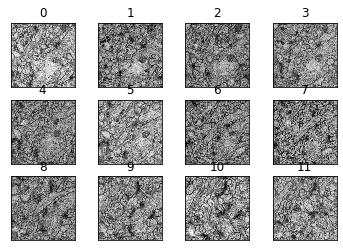

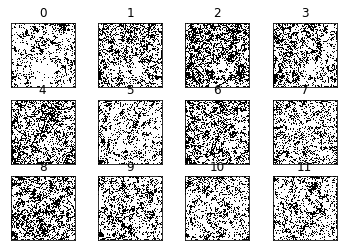

In [9]:
image_path = "src/datasets/ISBI/test/image/"
pred_path = "predict/"

image_list = os.listdir(image_path)
pred_list = os.listdir(pred_path)[1:]
# print(image_list)
# print(pred_list)
test_image = np.array([cv2.imread(image_path + image_list[p], -1) for p in range(len(image_list))])
pred_masks = np.array([cv2.imread(pred_path + pred_list[p], -1) for p in range(len(pred_list))])

show_image(test_image, num = 12)
show_image(pred_masks, num = 12)

```

|                | Acc  | IoU  | Dice | Sens | Spec |
| :------------: | :--: | :--: | :--: | ---: | ---- |
|   Train set    | 0.90 | 0.88 | 0.94 | 0.94 | 0.76 |
| Validation set | 0.92 | 0.90 | 0.95 | 0.96 | 0.77 |
```

根据表1评价指标结构，本案例构建的网络模型具有较好的性能，能够实现对测试集进行较为准确的预测，针对测试集的部分预测结果如图4所示。

<center>
    <img src="https://tva1.sinaimg.cn/large/e6c9d24ely1h5bwigmy47j20l2064dgy.jpg" alt="image-20220819101847606" style="zoom:50%;" />
    <br>
    <div style="color:orange;
    display: inline-block;
    color: #999;
    padding: 2px;">图4 模型预测结果</div>
</center>

### 3 总结

本案例基于MindSpore框架针对ISBI数据集，完成了数据读取、数据集创建、Unet模型构建，并根据特定需求自定义了评估指标和回调函数，进行了模型训练和评估，顺利完成了预测结果的输出。通过此案例进一步加深了对Unet模型结构和特性的理解，并结合MindSpore框架提供的文档和教程，掌握了利用Mindspore框架实现特定案例的流程，以及多种API的使用方法，为以后在实际场景中应用MindSpore框架提供支持。